## 用pandas來計算 RSI

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

In [2]:
db = sqlite3.connect('twstock2')
tsmc = pd.read_sql(con = db, sql = 'SELECT * FROM "2330"')

In [3]:
tsmc.index = pd.to_datetime(tsmc['Date'])
tsmc = tsmc[["收盤價"]]
tsmc['收盤價'] = pd.to_numeric(tsmc['收盤價'])
tsmc.head()

,收盤價
Date,
2020-08-26,442.0
2020-08-27,444.0
2020-08-28,435.0
2020-08-31,426.5
2020-09-01,435.0


## RSI
### 比較價格升降運動 表達價格強度
### 每天向上變動為U 向下為D
* 在價格上生的日子 U = 當日收盤價 - 昨日收盤價, D =0
* 在價格下跌的日子 U = 0, D = 昨日收盤價-當日收盤價
### RS = EMA(U, n)/ EMA(D, n)
### RSI = (1 - 1/1+RS)* 100% 
### n = 14 的時候最具代表 RSI升到70代表超買，跌至30代表超賣


In [4]:
tsmc['Dif'] = tsmc['收盤價'].diff()
tsmc.head()

,收盤價,Dif
Date,,
2020-08-26,442.0,NaN
2020-08-27,444.0,2.0
2020-08-28,435.0,-9.0
2020-08-31,426.5,-8.5
2020-09-01,435.0,8.5


In [5]:
def cal_U(num):
    if num >= 0:
        return num
    else:
        return 0
def cal_D(num):
    num = -num
    return cal_U(num)
tsmc['U'] = tsmc['Dif'].apply(cal_U)
tsmc['D'] = tsmc['Dif'].apply(cal_D)    
tsmc.head()

,收盤價,Dif,U,D
Date,,,,
2020-08-26,442.0,NaN,0.0,0.0
2020-08-27,444.0,2.0,2.0,0.0
2020-08-28,435.0,-9.0,0.0,9.0
2020-08-31,426.5,-8.5,0.0,8.5
2020-09-01,435.0,8.5,8.5,0.0


In [6]:
def rsi_n(df, n):
    col_u_day = "ema_u_" + str(n)
    col_d_day = "ema_d_" + str(n)
    col_rs_day = 'rs_' + str(n)
    col_rsi_day = 'rsi_' + str(n)

    df[col_u_day] = df['U'].ewm(span = n).mean()
    df[col_d_day] = df['D'].ewm(span = n).mean()
    df[col_rs_day] = df[col_u_day]/ df[col_d_day]
    df[col_rsi_day] = df[col_rs_day].apply(lambda rs:rs/(1+rs)* 100) 
    return df

In [7]:
tsmc = rsi_n(tsmc, 14)
tsmc.head()

,收盤價,Dif,U,D,ema_u_14,ema_d_14,rs_14,rsi_14
Date,,,,,,,,
2020-08-26,442.0,NaN,0.0,0.0,0.000000,0.000000,NaN,NaN
2020-08-27,444.0,2.0,2.0,0.0,1.071429,0.000000,inf,NaN
2020-08-28,435.0,-9.0,0.0,9.0,0.662139,3.438031,0.192593,16.149068
2020-08-31,426.5,-8.5,0.0,8.5,0.459572,4.986630,0.092161,8.438397
2020-09-01,435.0,8.5,8.5,0.0,2.557307,3.685626,0.693860,40.963236


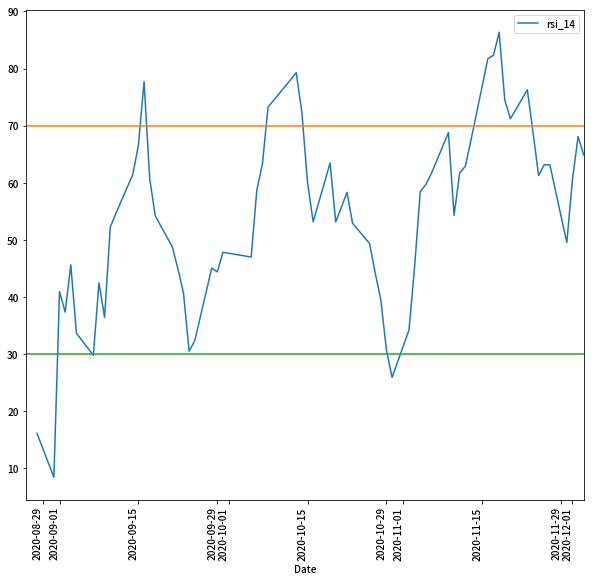

In [11]:
plt.figure(figsize = (10,10))
tsmc['rsi_14'].plot()
plt.plot(tsmc.index, [70]*len(tsmc.index))
plt.plot(tsmc.index, [30]*len(tsmc.index))
plt.legend()
plt.xticks(rotation=90)
plt.show()
